In [30]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import tensorflow as tf

In [31]:
!pip install pandas_market_calendars

In [32]:
import pandas_market_calendars as mcal

In [34]:
# Start and End date of stock data
start_date = pd.to_datetime('1999-11-18')
end_date   = pd.to_datetime('2020-09-02')

In [35]:
# Read names of Stocks we are interested in
symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/kassie-preprocessing/sp500.csv',index_col=False)
symbols = list(symbols['Symbol'].values)
symbols = sorted(symbols)

In [36]:
symbols = ['BF-B' if x=='BF.B' else x for x in symbols]
symbols = ['BRK-B' if x=='BRK.B' else x for x in symbols]

###Set start & end date and find the trading days between them
From the `pandas_market_calendars` package, find all the trading dates given a specific range of dates

In [37]:
# get trading days calendar
def create_market_cal(start, end):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start, end)
    market_cal = mcal.date_range(schedule, frequency='1D')
    market_cal = market_cal.tz_localize(None)
    market_cal = [i.replace(hour=0) for i in market_cal]
    return market_cal 


# Start and End date of stock data
start_date = pd.to_datetime('1999-11-18')
end_date   = pd.to_datetime('2020-09-02')

# Create a calendar
calendar = create_market_cal(start_date, end_date)



### Split the calendar dates in chunks of length 150
We do this because we are interested in data points that capture multiple time scales. We want to capture a stocks behavior over 50 & 100 & 150 days, and have all of this information in one data point that has a fixed length of 50.

In [39]:
# divide the calendar in 150 day chunks
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

# split trading days from start to end date in 50 day chunks
n = 150
list_of_date_chunk = list(divide_chunks(calendar, n)) 

# we skip the last date chunk bc it is not 150 days long
list_of_date_chunk = list_of_date_chunk[:-1]
len(list_of_date_chunk[-1])

150

### How we achieve multiscale data points

If you look at the fuction ```get_multiscale_values``` bellow, we notice that we want to extract infromation from a specific time window. 
* In order to capture the scale of price of 50 days we can just do `df_start_end[0:50]` and capture the first 50 consecutive days.


* In order to capture the timescale of 100 days we `df_start_end[0:100:2]`, thus each time we skip a value in between and are able to capture 100 days prices. We still have a length of 50.

Similarly for 150 days.



In [10]:
def get_multiscale_skipped_values(df_start_end):
  days_50 = df_start_end[-50:]
  days_100 = df_start_end[-100::2]
  days_150 = df_start_end[-150::3]
  dictionary = {'50_days': days_50['Adj Close'].values, '100_days': days_100['Adj Close'].values,
        '150_days': days_150['Adj Close'].values}
  return dictionary

def get_multiscale_consecutive_values(df_start_end):
  days_50 = df_start_end[-50:]
  days_100 = df_start_end[-100:]
  days_150 = df_start_end[-150:]

  days_50_all = pd.DataFrame(np.append(np.zeros((100,3)), days_50 ,0))
  days_50_all.loc[:, 0] = pd.to_numeric(days_50_all.loc[:, 0])
  days_50_all.columns = days_50.columns
  days_100_all = pd.DataFrame(np.append(np.zeros((50,3)), days_100,0))
  days_100_all.loc[:, 0] = pd.to_numeric(days_100_all.loc[:, 0])
  days_100_all.columns = days_50.columns
  dictionary = {'50_days': days_50_all['Adj Close'].values, '100_days': days_100_all['Adj Close'].values,
                    '150_days': days_150['Adj Close'].values}
  return dictionary

def scrape_yahoo(stock_name, start_date, end_date):
  # scrape data of each stock from yahoo
  try:
    df = web.DataReader(stock_name,'yahoo', start_date, end_date)
    df = df[['Adj Close','Volume']]
    df['Symbol'] =  stock_name
    find_flag = 1
    return df, find_flag
  except KeyError:
    print("Could not find data on ".format(stock_name))
    find_flag = 0
    return pd.DataFrame(), find_flag

total_prices_list_skipped_values = []
total_labels_list_consecutive_values = []
total_labels_list = []
n = 0
for stock_name in symbols[:1]:
  n = n + 1
  if n%100 == 0:
    print("{} stocksout of {} completed".format(n,len(symbols)))
  stock_df, find_flag = scrape_yahoo(stock_name, start_date, end_date)
  
  if find_flag == 0:
    print("Could not find data on {}".format(stock_name))
    continue

  prices_list_skipped_values = []
  prices_list_consecutive_values = []
  stock_name_list_values = []

  for item in list_of_date_chunk:
    start = item[0]
    end = item[-1]
    
    df_start_end = stock_df.loc[start:end]
    if len(df_start_end) >= 150:
      dictionary_skipped_values = get_multiscale_skipped_values(df_start_end)
      dictionary_consecutive_values = get_multiscale_consecutive_values(df_start_end)
    else:
      continue
  
    
    datapoint_skipped_values = pd.DataFrame(dictionary_skipped_values).to_numpy()
    datapoint_consecutive_values = pd.DataFrame(dictionary_consecutive_values).to_numpy()

    prices_list_skipped_values.append(datapoint_skipped_values)
    prices_list_consecutive_values.append(datapoint_consecutive_values)
    stock_name_list_values.append(stock_name)
    
  
  total_prices_list_skipped_values.append(prices_list_skipped_values)
  total_labels_list_consecutive_values.append(prices_list_consecutive_values)
  total_labels_list.append(stock_name_list_values)
  #print('Stock {} is done'.format(stock_name))

In [40]:
# we flatten the above total lists that contain all prices for all stocks in S&P
flattened_list_skipped_values = [y for x in total_prices_list_skipped_values for y in x]
flattened_list_consecutive_values = [y for x in total_labels_list_consecutive_values for y in x]
flattened_list_stock_names = [y for x in total_labels_list for y in x]

In [41]:
!pip install tslearn

In [42]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(flattened_list_skipped_values, flattened_list_stock_names, random_state=42)

In [43]:
#Skipped Values
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=5,random_state=0).fit(flattened_list_skipped_values)

In [44]:
clusters = km.predict(flattened_list_skipped_values)

new_arrays = []
for i in range(len(clusters)):
  cluster_np = np.full((flattened_list_skipped_values[i].shape[0],1), clusters[i])
  new_arrays.append(np.append(flattened_list_skipped_values[i], cluster_np, 1))

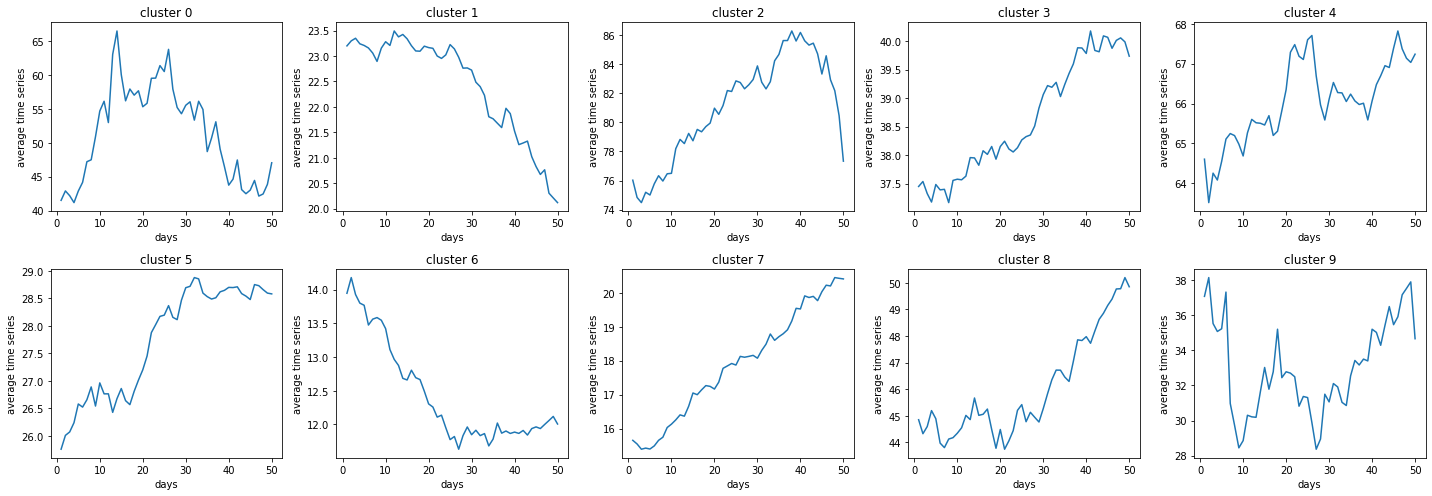

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

prices_skipped_clusters = pd.DataFrame(np.concatenate(new_arrays), columns = ['days50', 'days100', 'days150', 'clusters'])

fig, ax = plt.subplots(2, 5, figsize = (20, 7))

for i in range(0,10):

  clu_data = prices_skipped_clusters[prices_skipped_clusters['clusters'] == i].loc[:,['days50', 'days100', 'days150']]
  clu_data['average time series'] = clu_data.mean(axis = 1)
  clu_data['days'] = np.tile(range(1,51), len(clu_data)//len(range(1,51)))

  if i < 5:
    sns.lineplot(data = clu_data, x = 'days', y = 'average time series', ax = ax[0,i], ci = None)
    ax[0,i].set_title('cluster ' + str(i))
  
  else:
    sns.lineplot(data = clu_data, x = 'days', y = 'average time series', ax = ax[1,i-5], ci = None)
    ax[1,i-5].set_title('cluster '+ str(i))
  
fig.tight_layout()


In [74]:
#Consecutive values
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=5,random_state=0).fit(flattened_list_consecutive_values)
clusters_consecutive = km.predict(flattened_list_consecutive_values)

new_arrays_consecutive = []
for i in range(len(clusters_consecutive)):
  cluster_np_consecutive = np.full((flattened_list_consecutive_values[i].shape[0],1), clusters_consecutive[i])
  new_arrays_consecutive.append(np.append(flattened_list_consecutive_values[i], cluster_np_consecutive, 1))

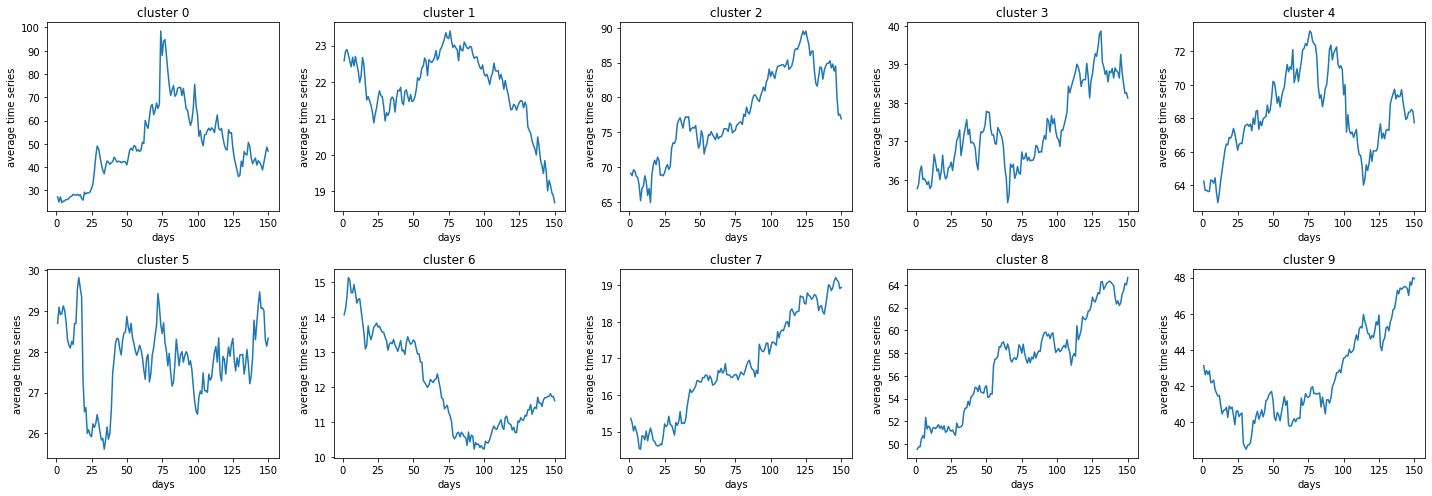

In [77]:
prices_consecutive_clusters = pd.DataFrame(np.concatenate(new_arrays_consecutive), columns = ['days50', 'days100', 'days150', 'clusters'])

fig, ax = plt.subplots(2, 5, figsize = (20, 7))

for i in range(0,10):

  clu_data = prices_consecutive_clusters[prices_consecutive_clusters['clusters'] == i].loc[:,['days50', 'days100', 'days150']]
  clu_data = clu_data.replace(0, np.nan)
  clu_data['average time series'] = clu_data.mean(axis = 1)
  clu_data['days'] = np.tile(range(1,151), len(clu_data)//len(range(1,151)))

  if i < 5:
    sns.lineplot(data = clu_data, x = 'days', y = 'average time series', ax = ax[0,i], ci = None)
    ax[0,i].set_title('cluster ' + str(i))
  
  else:
    sns.lineplot(data = clu_data, x = 'days', y = 'average time series', ax = ax[1,i-5], ci = None)
    ax[1,i-5].set_title('cluster '+ str(i))
  
fig.tight_layout()

In [ ]:
prices_ds =tf.data.Dataset.from_tensor_slices(tf.stack(flattened_list_prices))
names_ds =tf.data.Dataset.from_tensor_slices(tf.stack(flattened_list_stock_names))
# we create a data set with the labels and the prices
prices_names_ds = tf.data.Dataset.zip((prices_ds, names_ds))
print(prices_names_ds)

<ZipDataset shapes: ((50, 3), ()), types: (tf.float64, tf.string)>


In [ ]:
for price, label in prices_names_ds.take(2):
  print(price.shape, label)

(50, 3) tf.Tensor(b'A', shape=(), dtype=string)
(50, 3) tf.Tensor(b'A', shape=(), dtype=string)


<Figure size 432x288 with 0 Axes>

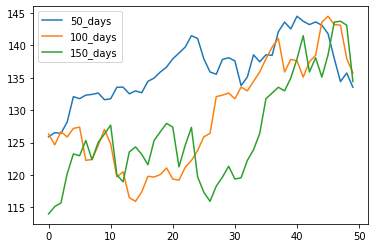

In [ ]:
import matplotlib.pyplot as plt

plt.figure(); datapoint.plot(); plt.legend(loc='best')

Save it on disk so we can load it without having to run this

In [ ]:
tf.data.experimental.save(prices_names_ds, 
                          '/content/sample_data/data',
                          compression=None, shard_func=None)

In [ ]:
d = tf.data.experimental.load(
    '/content/sample_data/data', element_spec =(tf.TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(), dtype=tf.string, name=None)))


In [ ]:
for price, label in d.take(2):
  print(price.shape, label)

(50, 3) tf.Tensor(b'A', shape=(), dtype=string)
(50, 3) tf.Tensor(b'A', shape=(), dtype=string)


In [ ]:
tfds.as_numpy(
    dataset, graph=None
)

